In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#based of https://www.tensorflow.org/tutorials/load_data/images
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import re
import pathlib
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

path = "/content/drive/MyDrive/fabric_classification/Fabrics_adjusted"

data_dir = pathlib.Path(path)

In [3]:
batch_size = 32
img_height = 400
img_width = 400
img_size = (img_height, img_width)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 4692 files belonging to 6 classes.
Using 3754 files for training.
Found 4692 files belonging to 6 classes.
Using 938 files for validation.
['Cotton', 'Denim', 'Nylon', 'Polyester', 'Silk', 'Wool']


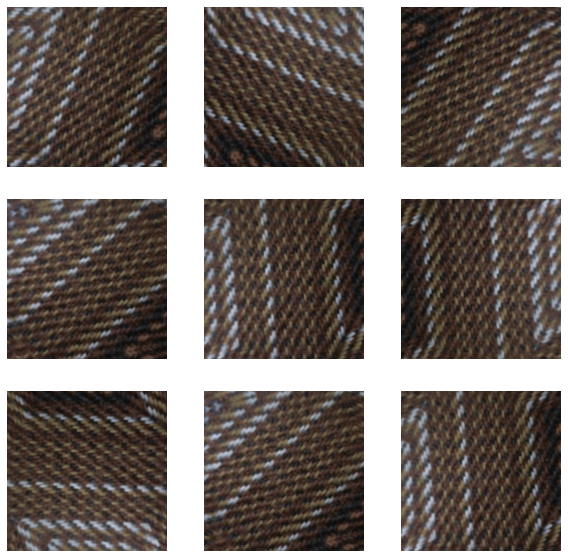

In [4]:
#data augmentation based of https://keras.io/examples/vision/image_classification_from_scratch/

#the augmentations to make
data_augmentation = tf.keras.Sequential(
    [
        #tf.keras.layers.RandomFlip("horizontal"),
        #tf.keras.layers.RandomFlip("vertical"),
        tf.keras.layers.RandomRotation(0.5)
    ]
)

#visualize the effect of the augmentations on a sample image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#apply augmentation to the training data
#augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [9]:
#based of https://www.tensorflow.org/tutorials/load_data/images
num_classes = 6

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  #tested 0.0005 and 0.00005 regularization
  tf.keras.layers.Conv2D(32, 3, input_shape=(32, 400, 400, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.0005)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.0005)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.0005)),

  tf.keras.layers.Dense(num_classes)
])

#tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.00005)),
 #tf.keras.layers.MaxPooling2D(),
  #tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.00005)),
  #tf.keras.layers.MaxPooling2D(),
  #tf.keras.layers.Flatten(),
  #tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.00005)),
  #tf.keras.layers.Dropout(0.8),

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

#based on https://towardsdatascience.com/ai-for-textiles-convolutional-neural-network-based-fabric-structure-classifier-c0db5433501d
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/fabric_classification/a_model_Aug_V4.h5', monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')
hist = model.fit(
    train_ds, 
    validation_data = val_ds, 
    epochs = 50, 
    verbose = 1, 
    callbacks = [checkpoint])

model.summary()

Epoch 1/50
 52/118 [============>.................] - ETA: 7s - loss: 7.4368 - accuracy: 0.4802

KeyboardInterrupt: ignored

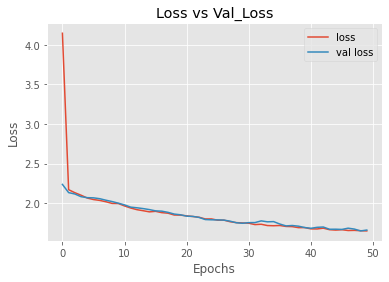

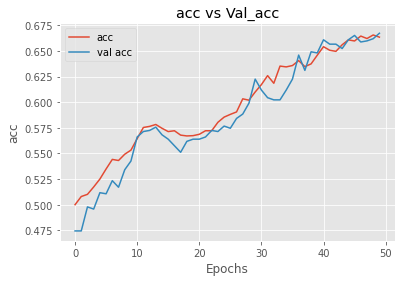

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(hist.history['accuracy'], label = 'acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

(938, 6)
(938,)
(938,)
[[398  15   0  32   0   0]
 [ 48  90   0   0   0   0]
 [ 31   0   0   9   0   0]
 [ 61   8   0 121   4   0]
 [  6   0   0  17  17   0]
 [ 52   6   0  23   0   0]]


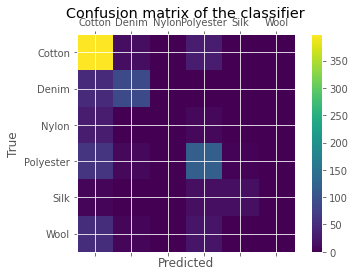

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

y_pred = model.predict(val_ds)#X
predicted_categories = tf.argmax(y_pred, axis=1)#X
true_categories = tf.concat([y for x, y in val_ds], axis=0)#y

print(y_pred.shape)
print(predicted_categories.shape)
print(true_categories.shape)

cm = confusion_matrix(true_categories, predicted_categories)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + class_names)
ax.set_yticklabels([''] + class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()